In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
%matplotlib inline
import math

In [2]:
df = pd.read_csv('train.csv', encoding='windows-1251')

C:\Users\vikto\conda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,Interval,Date,OrderDate,ClientID,ChannelID,OrderID,MaterialID,GroupID,Cluster,CancelFlag,OrderCnt,DeliveryType,prepay,count_edit
0,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3328810.0,61.0,NaN,0,1.0,Обычная доставка,0,1
1,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3281258.0,30.0,NaN,0,2.0,Обычная доставка,0,1
2,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3210734.0,10.0,NaN,0,1.0,Обычная доставка,0,1
3,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,3328848.0,61.0,NaN,0,2.0,Обычная доставка,0,1
4,12-14.,07/10/2018,05/10/2018,94112406,2,90102091007,3347801.0,17.0,NaN,0,10.0,Обычная доставка,0,1


In [4]:
df = df.drop(df[df.GroupID.isnull()].index)

In [5]:
df.shape

(9023079, 14)

In [6]:
df.shape

(9023079, 14)

In [7]:
df.OrderID.nunique()

354746

In [8]:
df.ClientID.nunique()

31234

Всего представлено 354746 различных заказов от 31234 уникальных клиента

In [9]:
df[['OrderID', 'CancelFlag']].drop_duplicates().CancelFlag.value_counts()

0    330992
1     23754
Name: CancelFlag, dtype: int64

Видим явный дисбаланс клаccсов

### EDA

In [10]:
OrderInfo = df[['Interval', 'Date', 'OrderDate', 'ClientID', 'ChannelID', 'OrderID',
                'Cluster', 'CancelFlag','DeliveryType', 'prepay', 'count_edit']].drop_duplicates()

In [11]:
OrderInfo.shape

(354746, 11)

In [12]:
def create_crosstab(df, col_name1, col_name2):
    cross = pd.crosstab(df[col_name1], df[col_name2])
    cross['Freq'] = cross.loc[:,1]/cross.sum(axis=1)
    return cross.sort_values('Freq', ascending=False)

#### Предоплата

In [13]:
create_crosstab(OrderInfo, 'prepay', 'CancelFlag')

CancelFlag,0,1,Freq
prepay,,,
0,256754,21622,0.077672
1,74238,2132,0.027917


Частота отмены заказов ниже на 5%, если была совершена предоплата.

#### Тип доставки 

In [14]:
OrderInfo.DeliveryType.unique()

array(['Обычная доставка', 'Доставка День в День'], dtype=object)

In [15]:
create_crosstab(OrderInfo, 'DeliveryType', 'CancelFlag')

CancelFlag,0,1,Freq
DeliveryType,,,
Обычная доставка,323129,23357,0.067411
Доставка День в День,7863,397,0.048063


Обычную доставку отменяют на 3% чаще.

#### Интервал доставки

In [16]:
cross_interval = pd.crosstab(OrderInfo.Interval, OrderInfo.CancelFlag)

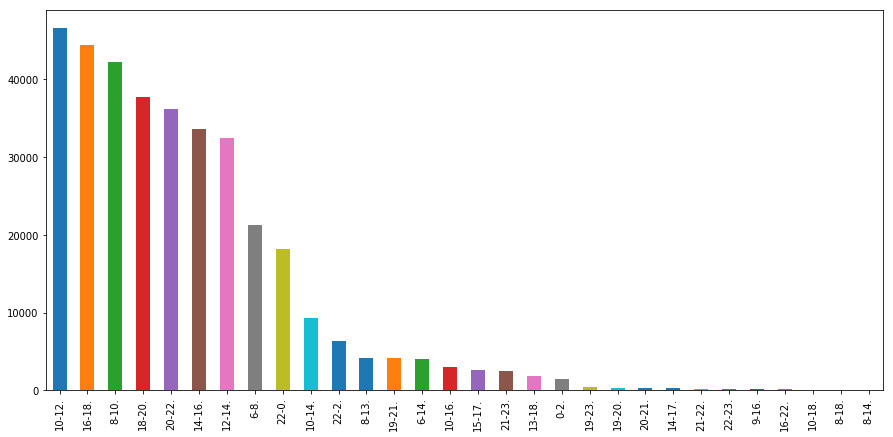

In [17]:
OrderInfo.Interval.value_counts().plot(kind='bar', figsize=(15,7))

Длина интервалов разная, есть пересекающиеся интервалы. Анализировать конкретные интервалы нет смысла, посмотрим на их длину.

In [18]:
OrderInfo['left_int'] = OrderInfo.Interval.str.split('-').str[0].astype(int)
OrderInfo['right_int'] = OrderInfo.Interval.str.split('-').str[1].str.replace('.','').astype(int)

In [19]:
OrderInfo.loc[OrderInfo[OrderInfo.right_int > OrderInfo.left_int].index, 'int_len'] = \
    OrderInfo.loc[OrderInfo[OrderInfo.right_int > OrderInfo.left_int].index, 'right_int'] - OrderInfo.loc[OrderInfo[OrderInfo.right_int > OrderInfo.left_int].index, 'left_int']

OrderInfo.loc[OrderInfo[OrderInfo.right_int < OrderInfo.left_int].index, 'int_len'] = \
    OrderInfo.loc[OrderInfo[OrderInfo.right_int < OrderInfo.left_int].index, 'right_int'] + (24 - OrderInfo.loc[OrderInfo[OrderInfo.right_int < OrderInfo.left_int].index, 'left_int'])

In [20]:
OrderInfo.head()

,Interval,Date,OrderDate,ClientID,ChannelID,OrderID,Cluster,CancelFlag,DeliveryType,prepay,count_edit,left_int,right_int,int_len
0,14-16.,03/10/2018,02/10/2018,93808186,2,90102063002,NaN,0,Обычная доставка,0,1,14,16,2.0
4,12-14.,07/10/2018,05/10/2018,94112406,2,90102091007,NaN,0,Обычная доставка,0,1,12,14,2.0
9,19-21.,05/10/2018,05/10/2018,93696397,2,90102092000,NaN,0,Доставка День в День,0,1,19,21,2.0
19,22-0.,12/10/2018,12/10/2018,93696397,2,90102103017,NaN,0,Обычная доставка,0,1,22,0,2.0
28,10-18.,17/10/2018,15/10/2018,93411902,2,90102104012,NaN,1,Обычная доставка,0,1,10,18,8.0


In [22]:
create_crosstab(OrderInfo, 'int_len', 'CancelFlag')

CancelFlag,0,1,Freq
int_len,,,
10.0,60,24,0.285714
7.0,128,45,0.260116
5.0,5262,728,0.121536
3.0,232,32,0.121212
6.0,2933,334,0.102234
8.0,3693,409,0.099707
4.0,14651,1498,0.092761
2.0,302968,20612,0.063700
1.0,1065,72,0.063325


Видим, что частота отказов меньше, если интервал доставки 1 или 2 часа.

#### Дней до доставки

In [23]:
OrderInfo.Date = pd.to_datetime(OrderInfo.Date, format='%d/%m/%Y')
OrderInfo.OrderDate = pd.to_datetime(OrderInfo.OrderDate, format='%d/%m/%Y')
OrderInfo['delivery_time'] = (OrderInfo.Date - OrderInfo.OrderDate)

In [24]:
OrderInfo.delivery_time = OrderInfo.delivery_time.apply(lambda x: x.days)

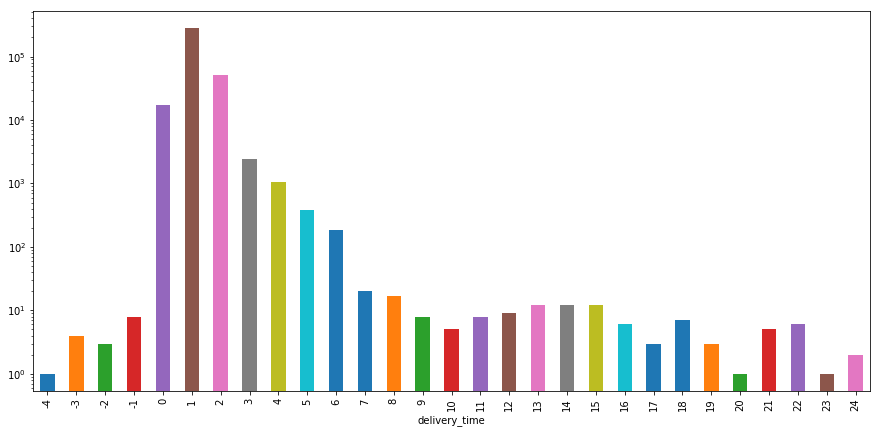

In [25]:
OrderInfo.groupby('delivery_time')['OrderID'].count().plot(kind='bar', figsize=(15,7), logy=True)

Видим, что есть записи, в которых, скорее всего, поменены местами дата заказа и доставки. Поменяем их местами

In [46]:
OrderInfo[OrderInfo.delivery_time < 0]

,Date,OrderDate,OrderID,prepay,CancelFlag,DeliveryType,Interval,left_int,right_int,int_len,delivery_time
594917,2018-01-29,2018-01-30,98354413765,1,1,Обычная доставка,10-12.,10,12,2.0,-1
1242129,2018-02-19,2018-02-22,98354627245,1,1,Обычная доставка,12-14.,12,14,2.0,-3
1350592,2018-02-20,2018-02-22,98354661653,1,1,Обычная доставка,18-20.,18,20,2.0,-2
1858173,2018-03-08,2018-03-12,98354824541,1,1,Обычная доставка,16-18.,16,18,2.0,-4
2161897,2018-03-19,2018-03-20,98354917909,1,1,Обычная доставка,14-16.,14,16,2.0,-1
2759584,2018-04-10,2018-04-13,98355100324,1,1,Обычная доставка,10-12.,10,12,2.0,-3
3637513,2018-05-16,2018-05-17,98355370076,1,1,Обычная доставка,6-14.,6,14,8.0,-1
4200018,2018-06-14,2018-06-15,98355548158,1,1,Обычная доставка,10-12.,10,12,2.0,-1
5619142,2018-08-27,2018-08-28,98356041142,1,1,Обычная доставка,10-12.,10,12,2.0,-1
5809497,2018-09-03,2018-09-05,98356113738,0,1,Обычная доставка,10-12.,10,12,2.0,-2


In [26]:
OrderInfo['delivery_time'] = (OrderInfo.Date - OrderInfo.OrderDate).apply(lambda x: x.days)

In [29]:
dtl0_index = OrderInfo[OrderInfo.delivery_time < 0].index
OrderInfo.loc[dtl0_index, 'Date'], OrderInfo.loc[dtl0_index,'OrderDate'] =\
        OrderInfo.loc[dtl0_index,'OrderDate'] , OrderInfo.loc[dtl0_index, 'Date']
OrderInfo.loc[dtl0_index,'delivery_time'] =\
        (OrderInfo.loc[dtl0_index, 'Date'] - OrderInfo.loc[dtl0_index,'OrderDate']).apply(lambda x: x.days)

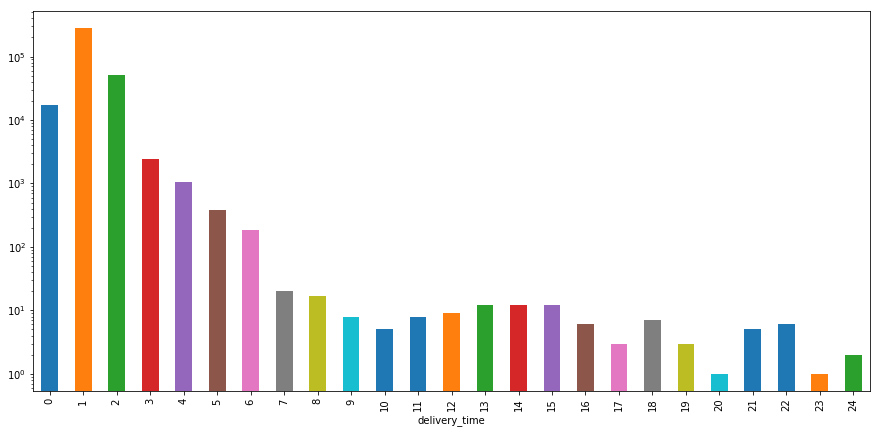

In [31]:
OrderInfo.groupby('delivery_time')['OrderID'].count().plot(kind='bar', figsize=(15,7), logy=True)

Доставку заказывают в большинстве случаев на день заказа, либо на ближайшие 2 дня

In [33]:
create_crosstab(OrderInfo, 'delivery_time', 'CancelFlag')

CancelFlag,0,1,Freq
delivery_time,,,
24,0,2,1.000000
23,0,1,1.000000
20,0,1,1.000000
18,1,6,0.857143
21,1,4,0.800000
19,1,2,0.666667
14,6,6,0.500000
22,3,3,0.500000
9,4,4,0.500000


#### Количество позиций группы в заказе

In [58]:
order_poz = df.groupby(['OrderID', 'GroupID'])['OrderCnt'].sum().unstack().fillna(0)

In [59]:
order_poz.head()

GroupID,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,41.0,42.0,46.0,48.0,53.0,55.0,59.0,61.0,63.0,66.0
OrderID,,,,,,,,,,,,,,,,,,,,,
90102063002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
90102091007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
90102092000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90102103017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
90102104012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0


#### Cluster

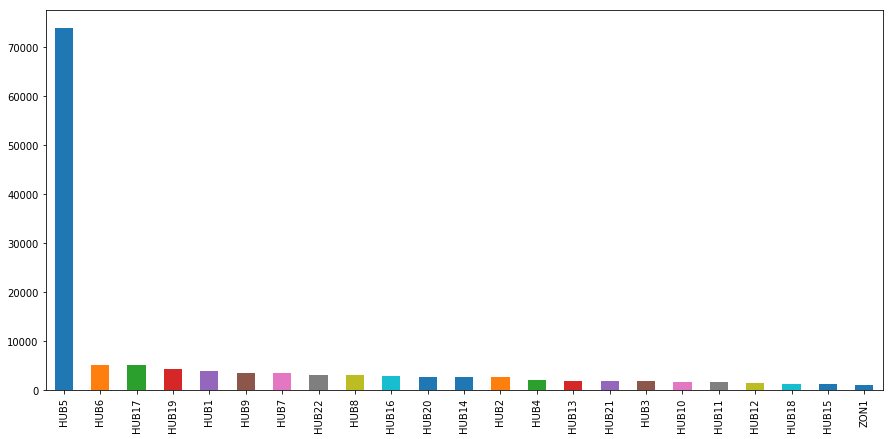

In [82]:
OrderInfo.Cluster.value_counts().plot(kind='bar', figsize=(15,7))

In [83]:
OrderInfo[OrderInfo.Cluster.isnull()].shape

(221762, 12)

In [34]:
create_crosstab(OrderInfo, 'Cluster', 'CancelFlag')

CancelFlag,0,1,Freq
Cluster,,,
HUB20,2535,257,0.092049
ZON1,1070,108,0.091681
HUB1,3610,363,0.091367
HUB11,1469,136,0.084735
HUB16,2714,235,0.079688
HUB19,3937,334,0.078202
HUB17,4680,373,0.073818
HUB21,1757,135,0.071353
HUB9,3348,256,0.071032


#### День недели

In [36]:
OrderInfo['weekday'] = OrderInfo.Date.apply(lambda x: x.weekday())

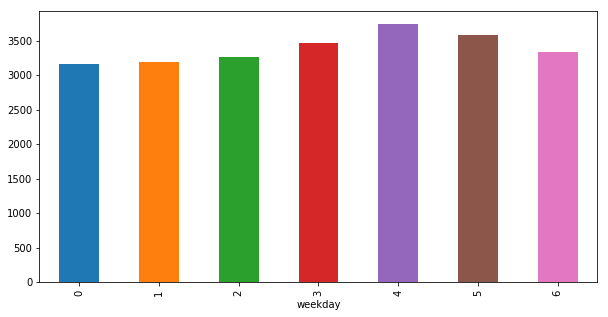

In [37]:
OrderInfo.groupby('weekday')['CancelFlag'].sum().plot(kind='bar', figsize=(10,5))

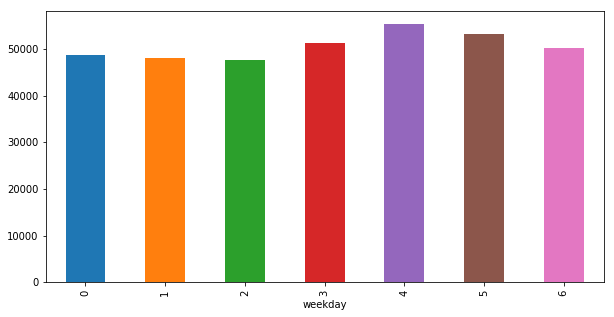

In [38]:
OrderInfo.groupby('weekday')['OrderID'].count().plot(kind='bar', figsize=(10,5))

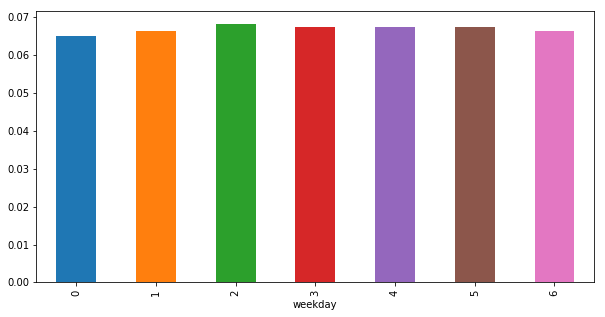

In [40]:
(OrderInfo.groupby('weekday')['CancelFlag'].sum() / 
    OrderInfo.groupby('weekday')['OrderID'].count()).plot(kind='bar', figsize=(10,5))

Видим, что количество отмен растет к пятнице, но на самом деле это связано с тем, что и количество заказов растет. Частота отмен при этом примерно на одном уровне.

In [103]:
OrderInfo.groupby('Date')['OrderID'].count().sort_values(ascending=False).head(20)

Date
2018-12-29    1579
2018-12-28    1508
2018-12-27    1488
2018-12-30    1329
2018-12-21    1318
2018-12-20    1316
2018-12-26    1298
2018-12-08    1286
2018-12-22    1285
2018-12-14    1280
2018-12-15    1261
2018-12-17    1250
2018-02-16    1239
2018-01-20    1236
2018-03-07    1234
2018-04-06    1234
2018-01-13    1229
2018-12-18    1228
2018-02-22    1227
2018-01-12    1217
Name: OrderID, dtype: int64

#### Анализ частоты отказов по дате

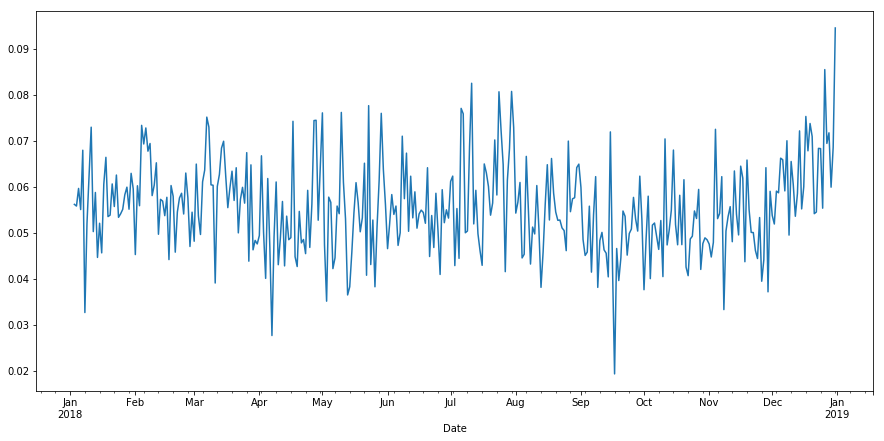

In [115]:
(df.groupby('Date')['CancelFlag'].sum() / df.groupby('Date')['OrderID'].count()).plot(figsize=(15,7))